<a href="https://colab.research.google.com/github/maxla777/Project-2/blob/Monique/Monique/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Models

In [3]:
csv_path = Path('/content/drive/MyDrive/Colab Notebooks/kraken_pull_EthExample_03202021.csv')
df_kraken=pd.read_csv(csv_path)
df_kraken.set_index(pd.to_datetime(df_kraken['Date'], infer_datetime_format=True), inplace=True)
df_kraken.drop(columns=['Date'], inplace=True)
df_kraken.head()

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-21,173.77,174.29,166.20,169.90,29212.243595,-0.022158,169.551804,168.762675,1.0,0.0,1.0,0.030150,0.032818,1.0,0.0,1.0,168.4515,6.214429,174.665929,162.237071,0.0,0.0,0.0,52.815498,0.0,0.0
2019-04-22,169.84,174.05,168.05,171.56,26074.473899,0.009770,169.826722,168.946971,1.0,0.0,1.0,0.028142,0.031764,1.0,0.0,1.0,168.7985,6.182904,174.981404,162.615596,0.0,0.0,0.0,54.232077,0.0,1.0
2019-04-23,171.56,176.94,168.84,170.51,35068.200810,-0.006120,169.919569,169.046773,1.0,0.0,1.0,0.026300,0.030800,1.0,0.0,1.0,169.2590,5.932951,175.191951,163.326049,0.0,0.0,0.0,53.145222,0.0,0.0
2019-04-24,170.06,171.01,160.22,165.72,51119.213850,-0.028092,169.352557,168.840498,1.0,0.0,1.0,0.026565,0.030711,1.0,0.0,1.0,169.6695,5.330713,175.000213,164.338787,0.0,0.0,0.0,48.381708,0.0,0.0
2019-04-25,165.60,166.71,146.50,152.09,73004.036166,-0.082247,167.034726,167.830124,0.0,-1.0,1.0,0.037502,0.035708,0.0,-1.0,1.0,168.9880,6.585730,175.573730,162.402270,1.0,0.0,0.0,37.956319,0.0,0.0


In [4]:
df_kraken.tail()

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910,0.006642,1764.071884,1564.701040,1.0,0.0,1.0,0.047424,0.056188,1.0,0.0,1.0,1667.1435,167.113171,1834.256671,1500.030329,0.0,0.0,0.0,55.179974,0.0,1.0
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516,0.010315,1771.798477,1573.525540,1.0,0.0,1.0,0.044289,0.055415,1.0,0.0,1.0,1684.2475,164.619259,1848.866759,1519.628241,0.0,0.0,0.0,56.112676,0.0,1.0
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795,-0.025875,1772.416148,1580.441979,1.0,0.0,1.0,0.042748,0.054948,1.0,0.0,1.0,1700.8095,155.740402,1856.549902,1545.069098,0.0,0.0,0.0,53.096928,0.0,0.0
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869,0.019031,1777.330547,1588.274512,1.0,0.0,1.0,0.040349,0.054223,1.0,0.0,1.0,1718.3220,146.681127,1865.003127,1571.640873,0.0,0.0,0.0,54.964465,0.0,1.0
2021-03-20,1810.38,1868.48,1801.38,1830.15,28829.379627,0.010920,1784.167996,1596.513679,1.0,0.0,1.0,0.037728,0.053478,1.0,0.0,1.0,1738.6945,130.908579,1869.603079,1607.785921,0.0,0.0,0.0,56.066041,0.0,1.0


In [5]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'RSI_signal']

# Construct training start and end dates
training_start = df_kraken.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-20'

# Construct testing start and end dates
testing_start =  '2020-08-21'
testing_end = df_kraken.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_kraken[x_var_list][training_start:training_end]
y_train = df_kraken['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_kraken[x_var_list][testing_start:testing_end]
y_test = df_kraken['Positive Return'][testing_start:testing_end]

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-04-21
Training End: 2020-08-20
Testing Start: 2020-08-21
Testing End: 2021-03-20


In [6]:
from sklearn.preprocessing import StandardScaler
#Create the StandardScaler instance
scaler = StandardScaler()

In [7]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [8]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# AdaBoost

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report, precision_recall_curve, roc_auc_score, hamming_loss, jaccard_score, matthews_corrcoef

In [10]:
# Fit a SKLearn linear regression using the training set (X_train, y_train):
AB_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=500,
    learning_rate=1,
    random_state=0
)
AB_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
AB_predictions = AB_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = AB_predictions
Results

,Positive Return,Predicted Value
Date,,
2020-08-21,0.0,1.0
2020-08-22,1.0,0.0
2020-08-23,0.0,0.0
2020-08-24,1.0,1.0
2020-08-25,0.0,1.0
...,...,...
2021-03-16,1.0,1.0
2021-03-17,1.0,1.0
2021-03-18,0.0,1.0


In [11]:
print(AB_model.get_params())

{'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': 'deprecated', 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None

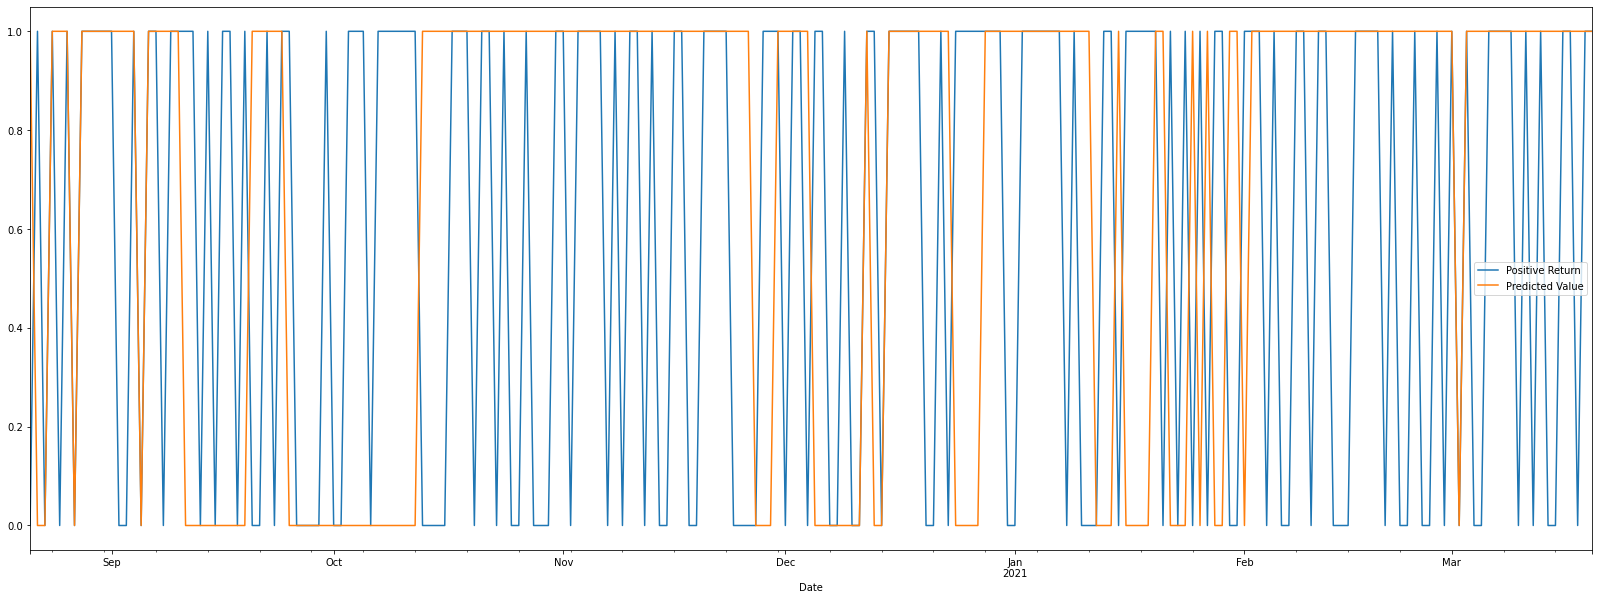

In [12]:
AB_Results = Results[['Positive Return','Predicted Value']]
AB_Results.plot(figsize=(28,10))

## Features

In [13]:
AB_importances = AB_model.feature_importances_

AB_importances_sorted = sorted(zip(AB_model.feature_importances_, df_kraken[x_var_list].columns), reverse=True)
AB_importances_sorted

[(0.268, 'bollinger_signal'),
 (0.226, 'RSI_signal'),
 (0.158, 'crossover_signal'),
 (0.14799999999999996, 'vol_trend_signal')]

## Metrics

In [14]:
# Compute confusion matrix
AB_cm = confusion_matrix(y_test, AB_predictions)
# Create a DataFrame with the labelled classes
AB_cm_df = pd.DataFrame(
    AB_cm, index=['Actual Not Positive', 'Actual Positive'], columns=['Predicted Not Positive', 'Predicted Positive']
)
# Set target names for the classification report
AB_target_names = ['Not Positive', 'Positive']
# Compute the accuracy score
AB_acc_score = accuracy_score(y_test, AB_predictions)
# Compute the balanced accuracy score
AB_bal_acc_score = balanced_accuracy_score(y_test, AB_predictions)
# Predict class probabilities for the features 
AB_probs = AB_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
AB_precision, AB_recall, _ = precision_recall_curve(y_test, AB_probs, pos_label=1)
# Compute the AUPRC - the area under the curve
AB_auprc_score = roc_auc_score(y_test, AB_probs)
# Compute the Matthews correlation coefficient (MCC)
AB_MCC_score = matthews_corrcoef(y_test, AB_predictions)
# Compute the Jaccard similarity coefficent score
AB_J_score = jaccard_score(y_test, AB_predictions)
# Compute the average Hamming loss
AB_H_loss = hamming_loss(y_test, AB_predictions)

Accuracy Score: 0.5
Balanced Accuracy Score: 0.464
Matthews correlation coefficient score: -0.079
Jaccard similarity coefficient score: 0.442
Average Hamming Loss: 0.5
Classification Report:
              precision    recall  f1-score   support

Not Positive       0.35      0.25      0.29        88
    Positive       0.56      0.68      0.61       124

    accuracy                           0.50       212
   macro avg       0.46      0.46      0.45       212
weighted avg       0.47      0.50      0.48       212

Confusion Matrix:


,Predicted Not Positive,Predicted Positive
Actual Not Positive,22,66
Actual Positive,40,84


Precision-Recall Curve
Area Under the Curve: 0.43


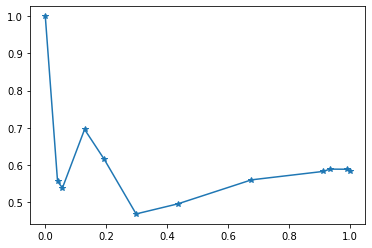

In [15]:
print("Accuracy Score:", round(AB_acc_score, ndigits=3))
print("Balanced Accuracy Score:", round(AB_bal_acc_score, ndigits=3))
print("Matthews correlation coefficient score:", round(AB_MCC_score, ndigits=3))
print("Jaccard similarity coefficient score:", round(AB_J_score, ndigits=3))
print("Average Hamming Loss:", round(AB_H_loss, ndigits=3))
print("Classification Report:")
print(classification_report(y_test, AB_predictions, target_names=AB_target_names))
print("Confusion Matrix:")
display(AB_cm_df)
print("Precision-Recall Curve")
print("Area Under the Curve:", round(AB_auprc_score, ndigits=3))
plt.plot(AB_recall, AB_precision, marker='*')

## Save Model

In [16]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(AB_model, 'AdaBoost_model.joblib') 

# Load saved model to use on other datasets
# AB_model = load('AdaBoost_model.joblib') 


# Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [18]:
# Fit a SKLearn linear regression using just the training set (X_train, y_train):
RF_model = RandomForestClassifier(n_estimators=500, 
                               max_depth=1,
                               criterion='gini', # gini or entropy, gini is default
                               random_state=0)
RF_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
RF_predictions = RF_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = RF_predictions
Results

,Positive Return,Predicted Value
Date,,
2020-08-21,0.0,1.0
2020-08-22,1.0,1.0
2020-08-23,0.0,1.0
2020-08-24,1.0,1.0
2020-08-25,0.0,1.0
...,...,...
2021-03-16,1.0,1.0
2021-03-17,1.0,1.0
2021-03-18,0.0,1.0


In [19]:
print(RF_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


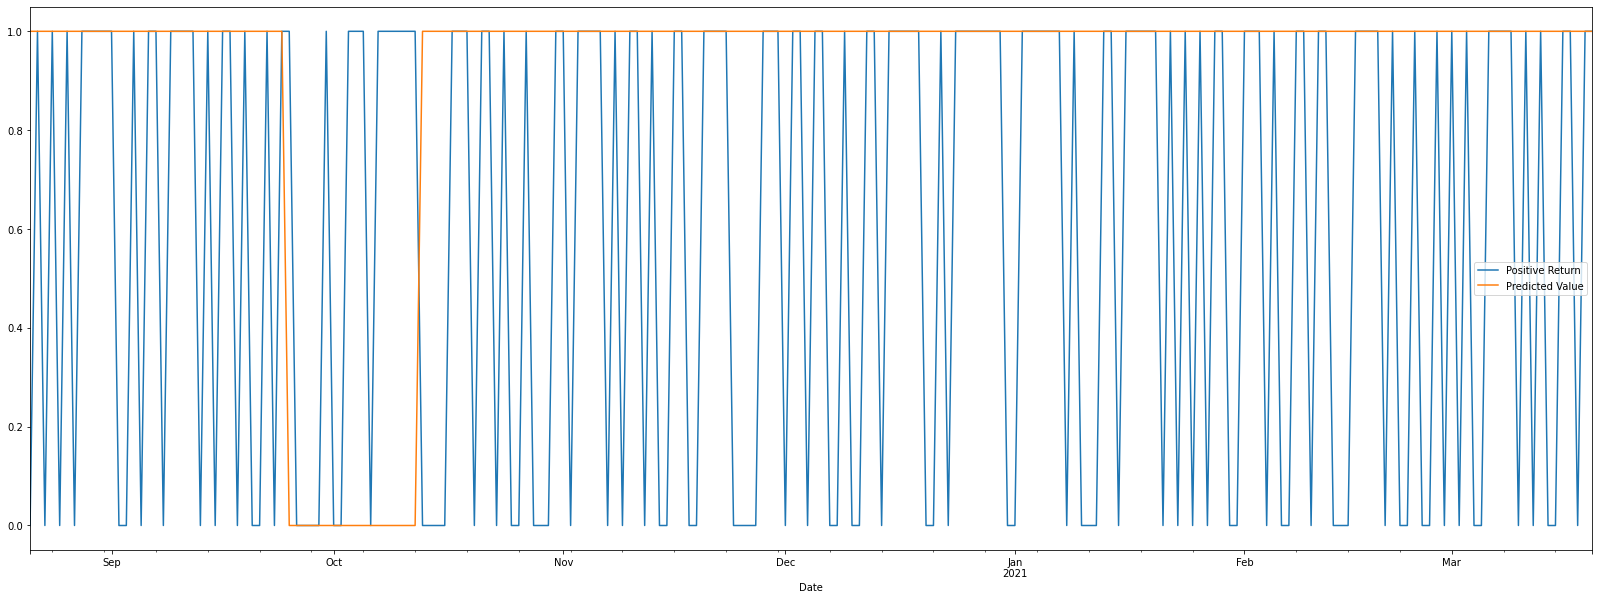

In [20]:
RF_Results = Results[['Positive Return','Predicted Value']]
RF_Results.plot(figsize=(28,10))

## Features

In [21]:
RF_importances = RF_model.feature_importances_

RF_importances_sorted = sorted(zip(RF_model.feature_importances_, df_kraken[x_var_list].columns), reverse=True)
RF_importances_sorted

[(0.396, 'RSI_signal'),
 (0.298, 'bollinger_signal'),
 (0.186, 'crossover_signal'),
 (0.12, 'vol_trend_signal')]

## Metrics

In [22]:
# Compute confusion matrix
RF_cm = confusion_matrix(y_test, RF_predictions)
# Create a DataFrame with the labelled classes
RF_cm_df = pd.DataFrame(
    RF_cm, index=['Actual Not Positive', 'Actual Positive'], columns=['Predicted Not Positive', 'Predicted Positive']
)
# Set target names for the classification report
RF_target_names = ['Not Positive', 'Positive']
# Compute the accuracy score
RF_acc_score = accuracy_score(y_test, RF_predictions)
# Compute the balanced accuracy score
RF_bal_acc_score = balanced_accuracy_score(y_test, RF_predictions)
# Predict class probabilities for the features 
RF_probs = RF_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
RF_precision, RF_recall, _ = precision_recall_curve(y_test, RF_probs, pos_label=1)
# Compute the AUPRC - the area under the curve
RF_auprc_score = roc_auc_score(y_test, RF_probs)
# Compute the Matthews correlation coefficient (MCC)
RF_MCC_score = matthews_corrcoef(y_test, RF_predictions)
# Compute the Jaccard similarity coefficent score
RF_J_score = jaccard_score(y_test, RF_predictions)
# Compute the average Hamming loss
RF_H_loss = hamming_loss(y_test, RF_predictions)

Accuracy Score: 0.566
Balanced Accuracy Score: 0.495
Matthews correlation coefficient score: -0.016
Jaccard similarity coefficient score: 0.551
Average Hamming Loss: 0.434
Classification Report:
              precision    recall  f1-score   support

Not Positive       0.39      0.08      0.13        88
    Positive       0.58      0.91      0.71       124

    accuracy                           0.57       212
   macro avg       0.49      0.50      0.42       212
weighted avg       0.50      0.57      0.47       212

Confusion Matrix:


,Predicted Not Positive,Predicted Positive
Actual Not Positive,7,81
Actual Positive,11,113


Precision-Recall Curve
Area Under the Curve: 0.44


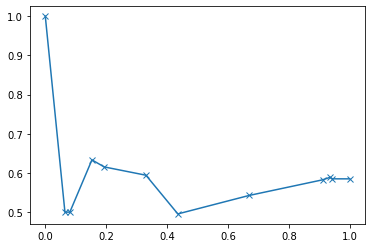

In [23]:
print("Accuracy Score:", round(RF_acc_score, ndigits=3))
print("Balanced Accuracy Score:", round(RF_bal_acc_score, ndigits=3))
print("Matthews correlation coefficient score:", round(RF_MCC_score, ndigits=3))
print("Jaccard similarity coefficient score:", round(RF_J_score, ndigits=3))
print("Average Hamming Loss:", round(RF_H_loss, ndigits=3))
print("Classification Report:")
print(classification_report(y_test, RF_predictions, target_names=RF_target_names))
print("Confusion Matrix:")
display(RF_cm_df)
print("Precision-Recall Curve")
print("Area Under the Curve:", round(RF_auprc_score, ndigits=3))
plt.plot(RF_recall, RF_precision, marker='x')

## Save Random Forest Model

In [24]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(RF_model, 'RandomForest_model.joblib') 

# Load saved model to use on other datasets
# RF_model = load('RandomForest_model.joblib') 
